In [ ]:
import numpy as np
import pandas as pd
from scipy.io import wavfile, loadmat
import matplotlib.pyplot as plt


DATASET_PATH = r"DREGON/free-flight_whitenoise-high_room1" 

# Base filename prefix (without extension)
BASE_FILENAME = r"DREGON_free-flight_whitenoise-high_room1"

NOISE_TEST_FILE = f"{DATASET_PATH}/{BASE_FILENAME}.wav"
AUDIO_TS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_audiots.mat"
IMU_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_imu.mat"
SOURCE_POS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_sourcepos.mat"
MOTORS_MAT_FILE = f"{DATASET_PATH}/{BASE_FILENAME}_motors.mat" # Optional to load
NOISE_TRAIN_FILE = r"DREGON\noise_training_room1.wav"


In [4]:
import scipy.io as sio

audio_ts_data = sio.loadmat(AUDIO_TS_MAT_FILE)['audio_timestamps']
imu_data = sio.loadmat(IMU_MAT_FILE)['imu'][0][0] #dtype=[('timestamps', 'O'), ('angular_velocity', 'O'), ('acceleration', 'O')]
source_pos_data = sio.loadmat(SOURCE_POS_MAT_FILE)['source_position'][0][0] #dtype=[('timestamps', 'O'), ('azimuth', 'O'), ('elevation', 'O'), ('distance', 'O')]
motors_data = sio.loadmat(MOTORS_MAT_FILE)['motor'][0][0] #[('command', 'O'), ('measured', 'O'), ('timestamps', 'O')]

In [5]:
motors_data_r = motors_data.copy()
motors_data_r[0] = motors_data[2]
motors_data_r[1] = motors_data[0]
motors_data_r[2] = motors_data[1]

In [ ]:
import scipy.io.wavfile as wav

sample_rate, audio_data = wav.read(NOISE_TEST_FILE)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Audio Data Shape: {audio_data.shape}")
print(f"Data Type: {audio_data.dtype}")

Sample Rate: 44100 Hz
Audio Data Shape: (2668292, 8)
Data Type: int32


In [106]:
# Analysis window size in miliseconds
window_length_ms = 512 # ms

# Frequency of sampling
fs = 16000 

# Microphone array
micPos = np.asarray([  [0.0420  ,  0.0615   , -0.0410  ],# mic 1
           [-0.0420,    0.0615,    0.0410],  # mic 2
           [-0.0615,    0.0420,   -0.0410],  # mic 3
           [-0.0615,   -0.0420,    0.0410],  # mic 4
           [-0.0420,   -0.0615,   -0.0410],  # mic 5
            [0.0420,   -0.0615,    0.0410],  # mic 6
            [0.0615,   -0.0420,   -0.0410],  # mic 7
			[0.0615,    0.0420,    0.0410] ])# mic 8     

isArrayMoving   = False # The microphone array is static
subArray        = [0,1,2,3,4,5,6,7] # Use all microphones
#subArray        = [3,4,6,7,8] # Use subset of less windy microphones
sceneTimeStamps = []  # Both array and sources are statics => no time stamps

# Localization method
angularSpectrumMeth        = 'GCC-PHAT' # Local Angular spectrum method {'GCC-PHAT' 'GCC-NONLIN' 'MVDR' 'MVDRW' 'DS' 'DSW' 'DNM' 'MUSIC'}
pooling                    = 'sum'      # Pooling method {'max' 'sum'}
applySpecInstNormalization = 0          # 1: Normalize instantaneous local angular spectra - 0: No normalization
# Search space
azBound                    = [-179 ,180] # Azimuth search boundaries (°)
elBound                    = [-90 ,20]   # Elevation search boundaries (°)
gridRes                    = 1          # Resolution (°) of the global 3D reference system {theta (azimuth),phi (elevation)}
alphaRes                   = 5          # Resolution (°) of the 2D reference system defined for each microphone pair
# Multiple sources parameters
nsrce                      = 1          # Number of sources to be detected
minAngle                   = 10         # Minimum angle between peaks
# Moving sources parameters
blockDuration_sec          = []         # Block duration in seconds (default []: one block for the whole signal)
blockOverlap_percent       = 0          # Requested block overlap in percent (default []: No overlap) - is internally rounded to suited values
# Wiener filtering
enableWienerFiltering      = 1             # 1: Process a Wiener filtering step in order to attenuate / emphasize the provided excerpt signal into the mixture signal. 0: Disable Wiener filtering
wienerMode                 = 'Attenuation' # Wiener filtering mode {'[]' 'Attenuation' 'Emphasis'} - In this example considered signal (noise) is attenuated in the mixture
# Display results
specDisplay                = 0          # 1: Display angular spectrum found and sources directions found - 0: No display
# Other parameters
speedOfSound               = 343        # Speed of sound (m.s-1) - typical value: 343 m.s-1 (assuming 20°C in the air at sea level)
fftSize_sec                = []         # FFT size in seconds (default []: 0.064 sec)
freqRange                  = []         # Frequency range to aggregate the angular spectrum : [] means no specified range
# Debug
angularSpectrumDebug       = 0          # Flag to enable additional plots to debug the angular spectrum aggregation


In [107]:
sMBSSParam = {
    'angularSpectrumMeth': angularSpectrumMeth,
    'speedOfSound': speedOfSound,
    'fftSize_sec': fftSize_sec if fftSize_sec else 0.064, # Handle MATLAB's default []
    'blockDuration_sec': blockDuration_sec if blockDuration_sec else None, # Handle MATLAB's default []
    'blockOverlap_percent': blockOverlap_percent,
    'pooling': pooling,
    'azBound': azBound,
    'elBound': elBound,
    'gridRes': gridRes,
    'alphaRes': alphaRes,
    'minAngle': minAngle,
    'nsrce': nsrce,
    'fs': fs,
    'applySpecInstNormalization': applySpecInstNormalization,
    'specDisplay': specDisplay,
    'enableWienerFiltering': enableWienerFiltering,
    'wienerMode': wienerMode,
    'freqRange': freqRange if freqRange else [0, fs/2], # Handle MATLAB's default []
    'micPos': micPos.T,  # MATLAB uses ' for transpose, Python needs .T for NumPy arrays
    'isArrayMoving': isArrayMoving,
    'subArray': subArray,
    'sceneTimeStamps': sceneTimeStamps,
    'angularSpectrumDebug': angularSpectrumDebug
}

print("sMBSSParam dictionary created.")



sMBSSParam dictionary created.


In [ ]:
from scipy.signal import resample_poly
import os

print("Loading data...")

# Noisy signal (already loaded as 'audio_data' and 'sample_rate')
# In your previous snippet, audio_data is the full signal.
# MATLAB's 'noisy_test_path' would correspond to your NOISE_TEST_FILE
# Here, `audio_data` is your `noisy_signal` and `sample_rate` is `fs_true` initially.
noisy_signal = audio_data.copy() # Make a copy if you plan to modify it
fs_true_noisy = sample_rate # The original sample rate of the loaded audio

# Resample if fs (target) is different from fs_true_noisy (original)
# Using resample_poly for potentially better quality than simple interpolation
if fs != fs_true_noisy:
    # Ensure audio_data is float for resampling
    if noisy_signal.dtype != np.float32 and noisy_signal.dtype != np.float64:
        noisy_signal = noisy_signal.astype(np.float64) / np.max(np.abs(noisy_signal))
    print(f"Resampling noisy signal from {fs_true_noisy} Hz to {fs} Hz...")
    noisy_signal = resample_poly(noisy_signal, fs, fs_true_noisy, axis=0)
    print("Resampling complete.")

noisy_signal_length = noisy_signal.shape[0] # Get length of noise (number of samples)

# Use subarray of microphones
# In Python, list indexing starts from 0. If `subArray` is [1,2,3,4,5,6,7,8]
# you need to convert it to 0-based for numpy indexing.
# Assuming `audio_data` (your `noisy_signal`) has channels as columns
if subArray: # Only apply if subArray is not empty
    noisy_signal = noisy_signal[:, subArray] # Use the 0-indexed subarray


# Audio timestamps
# Your `audio_ts_data` from previous snippet is already loaded.
# MATLAB's `str = load(audiots_path); audio_ts = str.audio_timestamps;` is equivalent.
audio_ts = audio_ts_data.flatten() # Ensure it's a 1D array

t0 = audio_ts[0]
audio_ts = audio_ts - t0 # Set audio start to time 0

# Resample audio timestamps
# Timestamps need to be resampled based on the new audio length and original duration
# Calculate the ratio of new length to old length
if fs != fs_true_noisy:
    original_duration_samples = noisy_signal_length * (fs_true_noisy / fs) # Approximate original length before resampling signal
    num_audio_samples = noisy_signal.shape[0] # Current (resampled) number of audio samples
    # Create a new time axis for the resampled signal
    audio_ts = np.linspace(0, (num_audio_samples - 1) / fs, num_audio_samples)
    print("Resampled audio timestamps generated.")


# Source positions
# Your `source_pos_data` from previous snippet is already loaded.
# MATLAB's `str=load(sourcepos_path); spos = str.source_position;` is equivalent.
s_az = source_pos_data['azimuth'].flatten()
s_el = source_pos_data['elevation'].flatten()
pos_ts = source_pos_data['timestamps'].flatten() - t0 # Set audio start to time 0


# Noise training signal for Wiener filter
# This assumes `NOISE_TEST_FILE` exists and contains a WAV file.
if os.path.exists(NOISE_TEST_FILE):
    fs_true_noise_training, x_noise = wavfile.read(NOISE_TEST_FILE)
    if x_noise.dtype != np.float32 and x_noise.dtype != np.float64:
        x_noise = x_noise.astype(np.float64) / np.max(np.abs(x_noise))

    if fs != fs_true_noise_training:
        print(f"Resampling noise training signal from {fs_true_noise_training} Hz to {fs} Hz...")
        x_noise = resample_poly(x_noise, fs, fs_true_noise_training, axis=0)
        print("Noise training resampling complete.")
    
    # Use subarray of microphones
    if subArray:
        x_noise = x_noise[:, subArray]
else:
    x_noise = None # Or handle the case where the file doesn't exist appropriately
    print(f"Warning: Noise training file not found at {NOISE_TEST_FILE}. Wiener filtering might be affected.")


print('Data are loaded.\n')


Loading data...
Resampling noisy signal from 44100 Hz to 16000 Hz...
Resampling complete.
Resampled audio timestamps generated.
Resampling noise training signal from 44100 Hz to 16000 Hz...
Noise training resampling complete.
Data are loaded.



In [120]:
import numpy as np
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy.linalg import pinv, eigh

# --- Global constant for numerical stability ---
EPSILON = 1e-10

# --- Helper Functions ---

def _sph2cart(az_deg, el_deg, r=1.0):
    """
    Converts spherical coordinates (azimuth, elevation, radius) to Cartesian coordinates.
    Standard convention:
    azimuth (theta) from -180 to 180 (0 along +x, 90 along +y)
    elevation (phi) from -90 to 90 (0 in xy-plane, 90 along +z)
    """
    az_rad = np.deg2rad(az_deg)
    el_rad = np.deg2rad(el_deg)

    x = r * np.cos(el_rad) * np.cos(az_rad)
    y = r * np.cos(el_rad) * np.sin(az_rad)
    z = r * np.sin(el_rad)
    return np.array([x, y, z])

def _compute_steering_vector(mic_pos, direction_vector, freq, speed_of_sound):
    """
    Computes the steering vector for a given frequency and direction.
    Steering vector 'a(f, d)' describes the phase delays for a plane wave
    arriving from direction 'd' at each microphone.

    Args:
        mic_pos (np.ndarray): Microphone positions (3, num_mics).
        direction_vector (np.ndarray): Unit vector pointing to the source (3,).
        freq (float): Frequency in Hz.
        speed_of_sound (float): Speed of sound in m/s.

    Returns:
        np.ndarray: Steering vector (num_mics,).
    """
    k_vec = (2 * np.pi * freq / speed_of_sound) * direction_vector
    steering_vector = np.exp(-1j * np.dot(k_vec, mic_pos))
    return steering_vector

def _estimate_cross_spectral_matrix(Y_f, num_mics):
    """
    Estimates the Cross-Spectral Matrix (CSM) from microphone FFTs.
    R_f = E[Y_f * Y_f^H] (expected value, typically estimated by averaging)

    Args:
        Y_f (np.ndarray): FFTs of microphone signals for a single frequency bin.
                          Shape: (num_mics,).
        num_mics (int): Number of microphones.

    Returns:
        np.ndarray: Estimated Cross-Spectral Matrix for that frequency. (num_mics, num_mics).
    """
    return np.outer(Y_f, Y_f.conj().T)

def _apply_wiener_filter_spectral_subtraction(noisy_spectrum, noise_spectrum_estimate, mode='Attenuation', alpha=1.0, beta=0.01):
    """
    Applies a simplified spectral subtraction-based Wiener-like filter.
    This is a basic placeholder; a full Wiener filter is more complex.

    Args:
        noisy_spectrum (np.ndarray): Complex spectrum of the noisy signal (for one channel).
        noise_spectrum_estimate (np.ndarray): Magnitude spectrum of the estimated noise.
        mode (str): 'Attenuation' or 'Emphasis'.
        alpha (float): Over-subtraction factor for noise.
        beta (float): Floor parameter to prevent musical noise.

    Returns:
        np.ndarray: Filtered complex spectrum.
    """
    if noise_spectrum_estimate.shape[0] != noisy_spectrum.shape[0]:
        min_len = min(noise_spectrum_estimate.shape[0], noisy_spectrum.shape[0])
        noise_spectrum_estimate = noise_spectrum_estimate[:min_len]
        noisy_spectrum = noisy_spectrum[:min_len]

    noisy_mag = np.abs(noisy_spectrum)
    noisy_phase = np.angle(noisy_spectrum)

    if mode == 'Attenuation':
        gain_mag = np.sqrt(np.maximum(noisy_mag**2 - alpha * noise_spectrum_estimate**2, beta * noise_spectrum_estimate**2)) / (noisy_mag + EPSILON)
    elif mode == 'Emphasis':
        gain_mag = np.sqrt(np.maximum(noisy_mag**2 + alpha * noise_spectrum_estimate**2, beta * noise_spectrum_estimate**2)) / (noisy_mag + EPSILON)
    else:
        gain_mag = 1.0 # No filtering

    filtered_spectrum = gain_mag * np.exp(1j * noisy_phase)
    return filtered_spectrum

def _compute_gcc_phat_angular_spectrum(
    signal_window, mic_pos, fs, speed_of_sound,
    nfft, az_bound, el_bound, grid_res, freq_mask,
    apply_spec_inst_normalization
):
    """
    Computes the angular spectrum using GCC-PHAT for a given signal window.
    Optimized for performance by pre-calculating theoretical TDOAs for the grid
    and using vectorized NumPy operations.
    """
    num_mics = mic_pos.shape[1]

    azimuth_grid = np.arange(az_bound[0], az_bound[1] + grid_res, grid_res)
    elevation_grid = np.arange(el_bound[0], el_bound[1] + grid_res, grid_res)

    angular_spectrum_grid = np.zeros((len(azimuth_grid), len(elevation_grid)), dtype=float)

    # Pre-compute all direction vectors for the grid
    az_rad_grid = np.deg2rad(azimuth_grid[:, np.newaxis]) # Shape (len(az), 1)
    el_rad_grid = np.deg2rad(elevation_grid[np.newaxis, :]) # Shape (1, len(el))

    x_dirs = np.cos(el_rad_grid) * np.cos(az_rad_grid)
    y_dirs = np.cos(el_rad_grid) * np.sin(az_rad_grid)
    z_dirs = np.sin(el_rad_grid) * np.ones_like(az_rad_grid) # Ensure broadcasting

    all_direction_vectors = np.stack([x_dirs, y_dirs, z_dirs], axis=0) # Resulting shape (3, len(az), len(el))

    # Get FFTs of all microphone signals for the current window
    S_f = fft(signal_window, n=nfft, axis=0) # Shape: (nfft, num_mics)

    # Iterate over all possible microphone pairs
    for i in range(num_mics):
        for j in range(i + 1, num_mics):
            mic1_pos = mic_pos[:, i]
            mic2_pos = mic_pos[:, j]

            # Compute GCC-PHAT for the pair in frequency domain
            G_xy_f = S_f[:, i] * np.conj(S_f[:, j])

            # Apply PHAT weighting: 1 / |G_xy(f)|
            denom = np.abs(G_xy_f)
            denom[denom < EPSILON] = EPSILON # Avoid division by zero
            G_xy_phat = G_xy_f / denom

            # Apply frequency mask
            G_xy_phat_filtered = G_xy_phat * freq_mask

            # Inverse FFT to get GCC-PHAT in time domain (cross-correlation)
            R_xy_phat = np.real(ifft(G_xy_phat_filtered)) # Shape (nfft,)

            # Calculate theoretical TDOAs for all grid points for *this* mic pair
            mic_dist_vector = mic1_pos - mic2_pos # Shape (3,)

            # Corrected line for vectorized dot product:
            tau_theoretical_grid = np.einsum('i,ijk->jk', mic_dist_vector, all_direction_vectors) / speed_of_sound

            # Convert theoretical TDOAs to integer sample delays
            delay_samples_theoretical_grid = tau_theoretical_grid * fs

            # Map these delays to indices in the R_xy_phat array
            delay_indices_grid = (np.round(delay_samples_theoretical_grid).astype(int)) % nfft
            # Ensure indices are positive (Python's % handles negative numbers differently for arrays)
            delay_indices_grid[delay_indices_grid < 0] += nfft

            # Add the contributions to the angular spectrum grid using advanced indexing
            angular_spectrum_grid += R_xy_phat[delay_indices_grid]

    # Normalization
    if apply_spec_inst_normalization:
        max_val = np.max(angular_spectrum_grid)
        if max_val > 0:
            angular_spectrum_grid = angular_spectrum_grid / max_val

    return angular_spectrum_grid
# --- Main Localization Function ---

def MBSS_locate_spec(windowed_noisy_signal, x_noise, sMBSSParam):
    """
    Performs Sound Source Localization (SSL) using various specified methods.

    Args:
        windowed_noisy_signal (np.ndarray): Audio data for the current window.
                                             Shape: (num_samples_in_window, num_mics)
        x_noise (np.ndarray or None): Noise training signal for Wiener filter.
                                      Shape: (num_samples, num_mics) or None.
        sMBSSParam (dict): Dictionary of localization parameters.

    Returns:
        tuple: (theta, phi)
            theta (np.ndarray): Array of estimated azimuths (degrees).
            phi (np.ndarray): Array of estimated elevations (degrees).
            These arrays might contain multiple peaks if nsrce > 1.
    """
    fs = sMBSSParam['fs']
    mic_pos = sMBSSParam['micPos']
    speed_of_sound = sMBSSParam['speedOfSound']
    angular_spectrum_method = sMBSSParam['angularSpectrumMeth']
    az_bound = sMBSSParam['azBound']
    el_bound = sMBSSParam['elBound']
    grid_res = sMBSSParam['gridRes']
    apply_spec_inst_normalization = sMBSSParam['applySpecInstNormalization']
    enable_wiener_filtering = sMBSSParam['enableWienerFiltering']
    wiener_mode = sMBSSParam['wienerMode']
    nsrce = sMBSSParam['nsrce']
    min_angle = sMBSSParam['minAngle']
    freq_range = sMBSSParam['freqRange']
    fft_size_sec = sMBSSParam['fftSize_sec']
    # spec_display = sMBSSParam['specDisplay'] # Not used here
    # angular_spectrum_debug = sMBSSParam['angularSpectrumDebug'] # Not used here

    num_samples_in_window, num_mics = windowed_noisy_signal.shape

    # Determine FFT size
    if fft_size_sec:
        nfft = int(np.power(2, np.ceil(np.log2(fft_size_sec * fs))))
    else:
        nfft = int(np.power(2, np.ceil(np.log2(0.064 * fs)))) # Default if not specified
    nfft = max(nfft, num_samples_in_window)

    # Calculate frequency bins for the positive half of the spectrum (up to Nyquist)
    freq_bins = np.fft.fftfreq(nfft, d=1/fs)
    positive_freq_mask = freq_bins >= 0

    # Apply frequency range filter
    min_freq, max_freq = freq_range if freq_range else [0, fs/2] # Default to full Nyquist range
    freq_filter_mask = (np.abs(freq_bins) >= min_freq) & (np.abs(freq_bins) <= max_freq)

    # Combine masks: ensure we only consider positive frequencies within the desired range
    final_freq_mask = positive_freq_mask & freq_filter_mask

    # 1. Estimate Noise Spectrum for Wiener Filter (if enabled)
    noise_spectrum_magnitude_estimate = None
    if enable_wiener_filtering and x_noise is not None and x_noise.size > 0:
        # Pad x_noise if necessary for FFT, or take a segment
        noise_fft_all_channels = fft(x_noise[:nfft], n=nfft, axis=0) # Take first nfft samples
        noise_spectrum_magnitude_estimate = np.mean(np.abs(noise_fft_all_channels), axis=1)

    # Calculate FFTs of the noisy signal window
    S_f = fft(windowed_noisy_signal, n=nfft, axis=0) # Shape: (nfft, num_mics)

    # Apply Wiener Filtering to each channel's spectrum
    if enable_wiener_filtering and noise_spectrum_magnitude_estimate is not None:
        S_f_filtered = np.zeros_like(S_f)
        for i in range(num_mics):
            S_f_filtered[:, i] = _apply_wiener_filter_spectral_subtraction(
                S_f[:, i], noise_spectrum_magnitude_estimate, wiener_mode
            )
        S_f = S_f_filtered

    # Define the search grid. This will be used for all methods.
    azimuth_grid = np.arange(az_bound[0], az_bound[1] + grid_res, grid_res)
    elevation_grid = np.arange(el_bound[0], el_bound[1] + grid_res, grid_res)
    angular_spectrum_grid = np.zeros((len(azimuth_grid), len(elevation_grid)), dtype=float)


    relevant_freq_indices = np.where(final_freq_mask)[0]

    if len(relevant_freq_indices) == 0:
        print("Warning: No relevant frequency bins found after filtering.")
        return np.array([np.nan]), np.array([np.nan])

    # --- Compute Angular Spectrum based on method ---
    if angular_spectrum_method == 'GCC-PHAT':
        # Call the optimized helper function for GCC-PHAT
        angular_spectrum_grid = _compute_gcc_phat_angular_spectrum(
            # Pass the original time-domain window; the helper will FFT it internally.
            windowed_noisy_signal, mic_pos, fs, speed_of_sound,
            nfft, az_bound, el_bound, grid_res, final_freq_mask,
            apply_spec_inst_normalization
        )

    elif angular_spectrum_method in ['MVDR', 'MVDRW', 'DS', 'DSW', 'DNM', 'MUSIC']:
        # For CSM-based methods, R_f_avg needs to be calculated from S_f (which might be filtered)
        R_f_avg = np.zeros((num_mics, num_mics), dtype=complex)
        for k in relevant_freq_indices:
            Y_f_k = S_f[k, :] # FFT values for all mics at freq bin k (already Wiener-filtered if enabled)
            R_f_avg += _estimate_cross_spectral_matrix(Y_f_k, num_mics)
        R_f_avg /= len(relevant_freq_indices)

        if angular_spectrum_method == 'MVDR':
            R_f_inv = pinv(R_f_avg + EPSILON * np.eye(num_mics))

            for az_idx, az in enumerate(azimuth_grid):
                for el_idx, el in enumerate(elevation_grid):
                    direction_vector = _sph2cart(az, el)
                    # Average steering vector over relevant frequencies
                    a_avg = np.zeros(num_mics, dtype=complex)
                    for k in relevant_freq_indices:
                        a_avg += _compute_steering_vector(mic_pos, direction_vector, freq_bins[k], speed_of_sound)
                    a_avg /= len(relevant_freq_indices)

                    denominator = np.real(a_avg.conj().T @ R_f_inv @ a_avg)
                    if denominator > EPSILON:
                        angular_spectrum_grid[az_idx, el_idx] = 1.0 / denominator
                    else:
                        angular_spectrum_grid[az_idx, el_idx] = 0.0

        elif angular_spectrum_method == 'MUSIC':
            eigenvalues, eigenvectors = eigh(R_f_avg)
            sorted_indices = np.argsort(eigenvalues)
            eigenvalues = eigenvalues[sorted_indices]
            eigenvectors = eigenvectors[:, sorted_indices]

            if num_mics > nsrce:
                E_N = eigenvectors[:, :num_mics - nsrce] # Noise subspace eigenvectors
                P_N = E_N @ E_N.conj().T # Projection matrix onto noise subspace
            else:
                print("Warning: nsrce is too high for MUSIC algorithm. No noise subspace found.")
                P_N = np.eye(num_mics) # Fallback, essentially no projection

            for az_idx, az in enumerate(azimuth_grid):
                for el_idx, el in enumerate(elevation_grid):
                    direction_vector = _sph2cart(az, el)
                    a_avg = np.zeros(num_mics, dtype=complex)
                    for k in relevant_freq_indices:
                        a_avg += _compute_steering_vector(mic_pos, direction_vector, freq_bins[k], speed_of_sound)
                    a_avg /= len(relevant_freq_indices)

                    denominator = np.real(a_avg.conj().T @ P_N @ a_avg)
                    if denominator > EPSILON:
                        angular_spectrum_grid[az_idx, el_idx] = 1.0 / denominator
                    else:
                        angular_spectrum_grid[az_idx, el_idx] = 0.0

        else:
            raise NotImplementedError(f"Angular spectrum method '{angular_spectrum_method}' is not fully implemented yet.")

    else:
        raise ValueError(f"Angular spectrum method '{angular_spectrum_method}' is not recognized.")

    # Final Normalization of angular spectrum
    if apply_spec_inst_normalization and np.max(angular_spectrum_grid) > 0:
        angular_spectrum_grid = angular_spectrum_grid / np.max(angular_spectrum_grid)

    # --- Find peaks in the angular spectrum ---
    estimated_azimuths = []
    estimated_elevations = []

    # Flatten the angular spectrum grid for peak finding
    flattened_spectrum = angular_spectrum_grid.flatten()
    grid_shape = angular_spectrum_grid.shape # (num_azimuths, num_elevations)

    if nsrce >= 1:
        # Find all local maxima above a simple prominence threshold
        peak_indices, properties = find_peaks(flattened_spectrum, prominence=0.01 * np.max(flattened_spectrum))
        
        # Sort peaks by amplitude (strongest first)
        peak_amplitudes = flattened_spectrum[peak_indices]
        sorted_peak_indices = peak_indices[np.argsort(peak_amplitudes)[::-1]] # Descending order

        selected_peaks = [] # Stores (flattened_idx, azimuth_deg, elevation_deg)
        azimuth_arr = np.arange(az_bound[0], az_bound[1] + grid_res, grid_res)
        elevation_arr = np.arange(el_bound[0], el_bound[1] + grid_res, grid_res)

        for p_idx_flat in sorted_peak_indices:
            if len(selected_peaks) >= nsrce:
                break

            # Convert flattened index back to 2D grid indices (az_idx, el_idx)
            p_az_idx, p_el_idx = np.unravel_index(p_idx_flat, grid_shape)
            p_az = azimuth_arr[p_az_idx]
            p_el = elevation_arr[p_el_idx]

            # Check min_angle constraint against already selected peaks
            is_far_enough = True
            for _, selected_az, selected_el in selected_peaks:
                # Calculate angular distance (great circle distance)
                az1_rad, el1_rad = np.deg2rad(p_az), np.deg2rad(p_el)
                az2_rad, el2_rad = np.deg2rad(selected_az), np.deg2rad(selected_el)

                # Haversine formula for angular distance on a unit sphere
                a = np.sin((el1_rad - el2_rad)/2)**2 + np.cos(el1_rad)*np.cos(el2_rad)*np.sin((az1_rad - az2_rad)/2)**2
                c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
                angular_distance_deg = np.rad2deg(c)

                if angular_distance_deg < min_angle:
                    is_far_enough = False
                    break

            if is_far_enough:
                selected_peaks.append((p_idx_flat, p_az, p_el))

        # Extract azimuths and elevations from selected peaks
        for _, az, el in selected_peaks:
            estimated_azimuths.append(az)
            estimated_elevations.append(el)
    else: # If nsrce is 0 or negative, no sources are expected
        estimated_azimuths = [np.nan]
        estimated_elevations = [np.nan]

    return np.array(estimated_azimuths), np.array(estimated_elevations)

In [121]:

import matplotlib.pyplot as plt
# --- Perform tests for different parameters ---
print('--------------- Start tests --------------\n')

# Initialization
# In Python, lists are often more flexible for dynamic appending,
# then converted to NumPy arrays at the end.
# However, if the size is known, pre-allocating with zeros is fine too.

# Window length in samples:
window_length_samples = int(np.round(window_length_ms * fs / 1000))
# Ensure window_length_samples is at least 1
if window_length_samples < 1:
    window_length_samples = 1
    print("Warning: window_length_samples was less than 1, set to 1.")


# Using float for division in the loop condition
# If noisy_signal is 1D (mono), make it 2D (samples, 1) for consistent indexing
if noisy_signal.ndim == 1:
    noisy_signal = noisy_signal[:, np.newaxis]

noisy_signal_length = noisy_signal.shape[0]

# Number of tests:
# MATLAB's `floor(noisy_signal_length/window_length_samples)` implies full windows.
# The loop condition `idx + window_length_samples < noisy_signal_length`
# handles the last partial window. Let's adjust `ntests` to reflect this.
ntests = 0 # Will be determined by the loop

# Use lists to dynamically collect results, then convert to NumPy arrays
analysis_ts_list = []
result_param_list = []

idx = 0 # Python uses 0-based indexing for start of window
count = 0

while (idx + window_length_samples) <= noisy_signal_length: # Use <= to include the last full window
    # Save analysis timestamp
    # In MATLAB: audio_ts(idx+round(window_length_samples/2))
    # Python: audio_ts[idx + int(np.round(window_length_samples / 2))]
    # Ensure this index is within bounds of audio_ts
    mid_window_idx = idx + int(np.round(window_length_samples / 2))
    if mid_window_idx < len(audio_ts):
        analysis_ts_list.append(audio_ts[mid_window_idx])
    else:
        # Handle cases where mid_window_idx might exceed audio_ts length due to rounding
        # For simplicity, if audio_ts is shorter than expected based on signal length,
        # you might need to interpolate or use the last available timestamp.
        # For now, let's append a dummy value or the last available timestamp
        analysis_ts_list.append(audio_ts[-1] if audio_ts.size > 0 else 0.0)
        print(f"Warning: Mid-window index {mid_window_idx} out of bounds for audio_ts (len {len(audio_ts)})")


    # Extract the windowed signal (Python uses slicing [start:end])
    # MATLAB: noisy_signal(idx:idx+window_length_samples,:)
    # Python: noisy_signal[idx : idx + window_length_samples, :]
    windowed_noisy_signal = noisy_signal[idx : idx + window_length_samples, :]

    # Perform SSL
    theta, phi = MBSS_locate_spec(windowed_noisy_signal, x_noise, sMBSSParam)

    # MATLAB: [phi,minidx] = min(phi); theta = theta(minidx);
    # This implies that `min` finds the minimum elevation and selects the
    # corresponding azimuth. This is a common way to select one source
    # when multiple peaks are found, often assuming the "main" source
    # has the minimum elevation, or sometimes it's the peak with max power.
    # If MBSS_locate_spec returns multiple (theta, phi) pairs, we need to select one.
    # Assuming MBSS_locate_spec returns NumPy arrays:
    if len(phi) > 0: # Ensure phi is not empty
        minidx = np.argmin(phi) # Get index of minimum elevation
        selected_phi = phi[minidx]
        selected_theta = theta[minidx]
    else:
        # Handle case where no sources are detected by MBSS_locate_spec
        selected_phi = np.nan # Or some other indicator for no detection
        selected_theta = np.nan


    # Save results in result vector
    result_param_list.append([selected_theta, selected_phi])

    idx += window_length_samples
    count += 1

print(f"Processed {count} windows.")
print('--------------- Tests finished --------------\n')

# Convert lists to NumPy arrays for plotting
analysis_ts = np.array(analysis_ts_list)
result_param = np.array(result_param_list)


--------------- Start tests --------------

Processed 118 windows.
--------------- Tests finished --------------



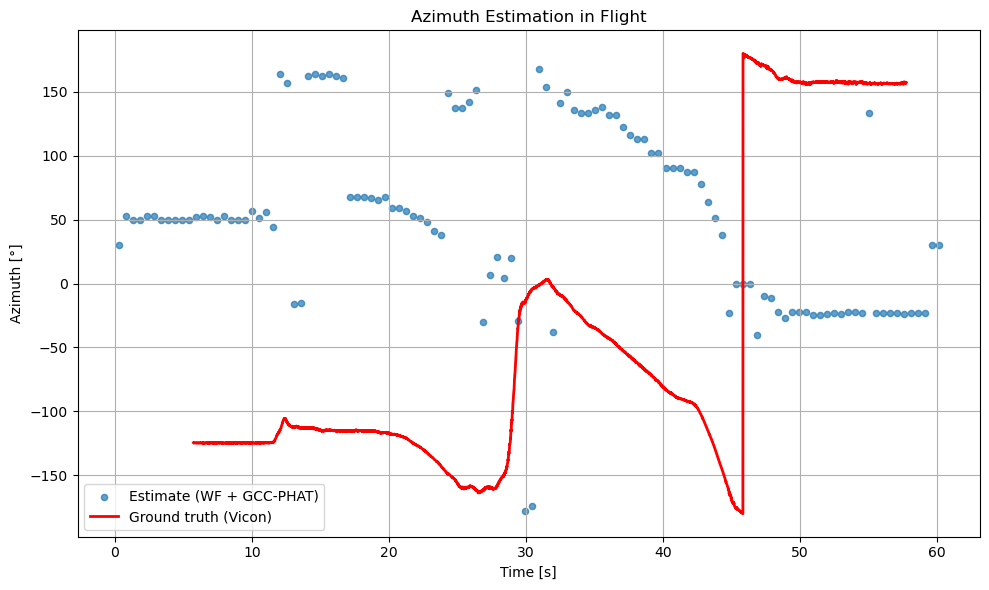

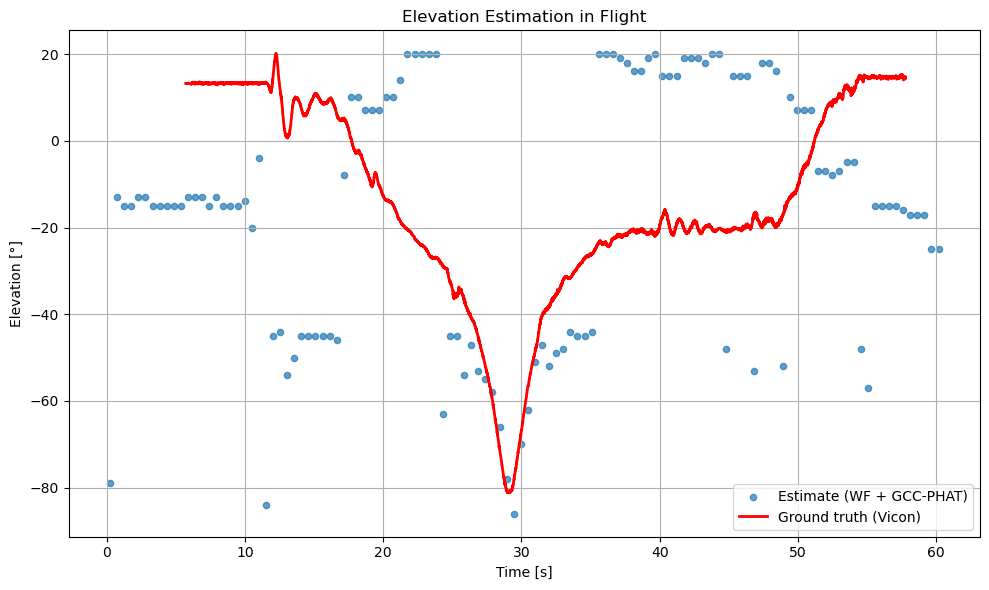

Plots generated for Azimuth and Elevation.


In [122]:
# --- Plotting ---

# Azimuth plot
plt.figure(figsize=(10, 6)) # Create a new figure with a specific size
plt.scatter(analysis_ts, result_param[:, 0], s=20, label='Estimate (WF + GCC-PHAT)', alpha=0.7) # 's' for marker size
plt.plot(pos_ts, s_az, 'r-', linewidth=2, label='Ground truth (Vicon)') # 'r-' for red line
plt.title('Azimuth Estimation in Flight')
plt.xlabel('Time [s]')
plt.ylabel('Azimuth [°]')
plt.legend()
plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust plot to prevent labels from overlapping
plt.show()

# Elevation plot
plt.figure(figsize=(10, 6))
plt.scatter(analysis_ts, result_param[:, 1], s=20, label='Estimate (WF + GCC-PHAT)', alpha=0.7)
plt.plot(pos_ts, s_el, 'r-', linewidth=2, label='Ground truth (Vicon)')
plt.title('Elevation Estimation in Flight')
plt.xlabel('Time [s]')
plt.ylabel('Elevation [°]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Plots generated for Azimuth and Elevation.")